In [1]:
import sys

sys.path.append("../")
from hamilton_neural_network import (
    TrainTestData,
    HamiltonianNeuralNetwork,
    LatentHamiltonianNeuralNetwork,
)
from hamilton_system import HamiltonianSystem
from pdf_models import NegLogIndepedentGaussians, NegLogNealFunnel
import tensorflow as tf
import matplotlib.pyplot as plt
from no_u_turn.nuts import NoUTurnSampling

tf.random.set_seed(0)


2.15.0


In [2]:
U = NegLogNealFunnel()
K = NegLogIndepedentGaussians(
    tf.constant([0.0, 0.0]), tf.constant([1.0, 1.0])
)
q0 = tf.constant([[0.0, 0.0]])
p0 = tf.random.normal(q0.shape)
T = 120.0
leap_frog_per_unit = 40
num_samples = 40
num_train = int(0.9 * num_samples * leap_frog_per_unit * T)

In [3]:
# train_test_data = TrainTestData(
#     num_samples, T, leap_frog_per_unit, q0, p0, U=U, K=K
# )
# samples = train_test_data()
# tf.io.write_file("../exps/demo3_train_test_data.txt", tf.io.serialize_tensor(samples))

In [4]:
file = tf.io.read_file("../exps/demo3_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
train_test_data = tf.random.shuffle(train_test_data)
train_data = train_test_data[:num_train, :]
test_data = train_test_data[num_train:, :]
print(train_data.shape, test_data.shape)
lhnn = LatentHamiltonianNeuralNetwork(3, 100, 2)
lhnn.build(input_shape=(1, 4))
train_hist, test_hist = lhnn.train(1000, 1000, 5e-4, train_data, test_data, save_dir="../exps/demo3_lhnn.weights.h5")

(172800, 8) (19240, 8)


Training started...
Epoch 0: Train loss 0.38912802934646606, Test loss 0.43456533551216125.
Epoch 100: Train loss 0.0009778050007298589, Test loss 0.0010252591455355287.
Epoch 200: Train loss 0.00023469123698305339, Test loss 0.0002617475693114102.
Epoch 300: Train loss 0.0039129541255533695, Test loss 0.003006431506946683.
Epoch 400: Train loss 0.0026316591538488865, Test loss 0.0012445636093616486.
Epoch 500: Train loss 0.002554116304963827, Test loss 0.0007100210641510785.
Epoch 600: Train loss 0.00020847012638114393, Test loss 0.00018283372628502548.
Epoch 700: Train loss 0.00040946397348307073, Test loss 0.0003044051700271666.
Epoch 800: Train loss 0.0005524347652681172, Test loss 0.0002951729984488338.
Epoch 900: Train loss 0.00013394527195487171, Test loss 0.0001754765398800373.
Training complete!


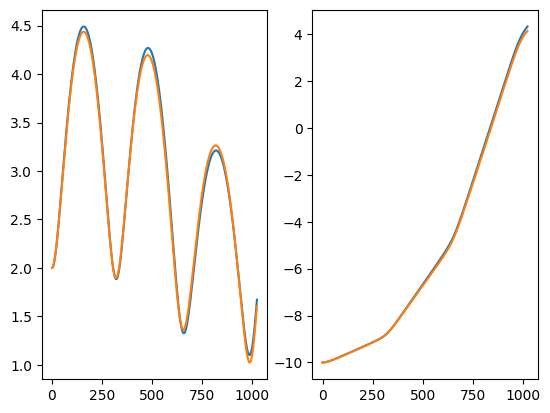

In [7]:
lhnn = LatentHamiltonianNeuralNetwork(3, 100, 2)
lhnn.build(input_shape=(1, 4))
lhnn.load_weights("../exps/demo3_lhnn.weights.h5")
U = NegLogNealFunnel()
K = NegLogIndepedentGaussians(
    tf.constant([0.0, 0.0]), tf.constant([1.0, 1.0])
)
q0 = tf.constant([[2.0, -10.0]])
p0 = tf.constant([[0.0, 0.0]])
leap_frog_per_unit = 40
n_steps = 1024
original_hamiltonian = HamiltonianSystem(U=U, K=K)

hist_original = original_hamiltonian.symplectic_integrate(
    q0, p0, 1 / leap_frog_per_unit, n_steps
)
hist_lhnn = lhnn.symplectic_integrate(q0, p0, 1 / leap_frog_per_unit, n_steps)

fig, ax = plt.subplots(1, 2)
ax[0].plot(hist_original[:, 0])
ax[0].plot(hist_lhnn[:, 0])
ax[1].plot(hist_original[:, 1])
ax[1].plot(hist_lhnn[:, 1])
plt.show()

In [ ]:
q0 = tf.constant([[0.0, 0.0]])
nuts = NoUTurnSampling(num_samples=25000, q0=q0, dt=0.025, lhnn=lhnn)
nuts()
q_hist = tf.concat(nuts.q_hist, axis=0)
plt.hist(q_hist.numpy()[10000:, 0].flatten(), bins=30, color="blue")
plt.show()

In [ ]:
file = tf.io.read_file("../exps/demo3_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
plt.scatter(train_test_data[:, 0], train_test_data[:, 1], marker="x", color="blue")
plt.show()